In [3]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from datetime import *
import math
from scipy.fft import fft, fftfreq
from scipy.signal import argrelextrema

In [4]:
# Importing all data set (main)
df = []
NUM_DF = 38
for i in range(NUM_DF):
    df.append(pd.read_csv('dataSetMain/current_' + str(i+1) + '.csv'))

In [5]:
# Importing dataSets for understanding
dfClear = pd.read_csv('barFailure/ccs10.csv')
dfClear.drop(dfClear.columns[0], axis=1, inplace=True)
dfBarFailure = pd.read_csv('barFailure/ccs88.csv')
dfBarFailure.drop(dfBarFailure.columns[0], axis=1, inplace=True)

In [6]:
# Global constant variables
fmax = 400
overlap = 0.5
PRINT = False
SAVE_FILE = True

In [86]:
# Static variables
globalFreqinces = pd.DataFrame(columns=['FTF at motor', 'BSF at motor', 'BPFO at motor', 'BPFI at motor', 'FTF at rotor', 'BSF at rotor',
    'BPFO at rotor', 'BPFI at rotor', 'rotor+1', 'rotor-1', 'rotor+2', 'rotor-2', 'stator x2', 'stator x3'])

In [87]:
class Bearing:
    def __init__(self, d : float, D : float, b : float, dMove : float, dBall : float, nBall : int, alpha : float = 0):
        self.d = d
        self.D = D
        self.b = b
        self.dMove = dMove
        self.dBall = dBall
        self.nBall = nBall
        self.alpha = alpha

    def getFreqinces(self, rotationFreq : float, place : str, index : int) -> list:
        value = self.dBall/self.dMove*math.cos(self.alpha)
        # Частота вращения сепаратора
        globalFreqinces.loc[index, 'FTF at ' + place] = rotationFreq/2*(1-value)
        # Частота перекатывания тел качения
        globalFreqinces.loc[index, 'BSF at ' + place] = rotationFreq*self.dMove/self.dBall/2*(1-value*value)
        # Частота наружного кольца
        globalFreqinces.loc[index, 'BPFO at ' + place] = rotationFreq*self.nBall/2*(1-value)
        # Частота внутреннего кольца
        globalFreqinces.loc[index, 'BPFI at ' + place] = rotationFreq*self.nBall/2*(1+value)

rotorBearing = Bearing(25, 52, 15, 39, 7.938, 9, 0)

In [170]:
class Model:
    def __init__(self, peaks : pd.DataFrame, index : int):
        # Getting main frequnces (as biggest number)
        self.powerFreqince = peaks.iloc[0]['freq']
        # Getting rotation frequnces
        firstHalf = peaks[peaks['freq'] < (self.powerFreqince-0.1)]
        self.motorFreqince = firstHalf.iloc[0]['freq']
        secondHalf = peaks[peaks['freq'] > (self.powerFreqince+0.1)]
        self.rotorFreqince = secondHalf.iloc[0]['freq']
        self.getBreaks(index)
        self.findCloseFreqinces(peaks, index)

    def getBreaks(self, index : int) -> None:
        # Getting important properties
        self.numPoles = round(self.powerFreqince / self.motorFreqince)
        self.slide = (self.motorFreqince*self.numPoles - self.powerFreqince)/self.powerFreqince

        # Getting list of dengerous frequncies
        rotorBearing.getFreqinces(self.motorFreqince, 'motor', index)
        rotorBearing.getFreqinces(self.rotorFreqince, 'rotor', index)

        # Adding rotor breaking
        for i in range(1, 3):
            globalFreqinces.loc[index, 'rotor+'+str(i)] = self.powerFreqince * (1 + i * self.slide)
            globalFreqinces.loc[index, 'rotor-'+str(i)] = self.powerFreqince * (1 - i * self.slide)

        # Adding stator breaking
        globalFreqinces.loc[index, 'stator x2'] = self.powerFreqince*2
        globalFreqinces.loc[index, 'stator x3'] = self.powerFreqince*3

    def findCloseFreqinces(self, peaks : pd.DataFrame, index : int) -> None:
        # Finding close freqiunces
        self.closest = []
        for i in range(len(globalFreqinces.columns)):
            for j in peaks['freq'].values:
                if (abs(globalFreqinces.iloc[index, i] - j) < 0.1):
                    self.closest.append([i, j])

    def print(self) -> None:
        print('Power grid freqince:', self.powerFreqince)
        print('Electric motor rotation frequnces:', self.motorFreqince)
        print('Rotor after multiplicator:', self.rotorFreqince)
        print("Num poles:", self.numPoles)
        print("Slide:", self.slide)
        print("\nPosible dangerous freqinces")
        for i in self.freq:
            print("Freq:", i['freq'], "type:", i['type'])
        print("\nClosest freqinces")
        for i in self.closest:
            print("Freq:", i[0], "close to:", i[1], "type:", i[2])

    def save(self, fileName : str, index : int) -> None:
        # Writing file
        file = open(fileName, "w")

        # Writing get model parameters
        file.write("Parameters\n")
        file.write('Power grid freqince: ' + str(self.powerFreqince) + '\n')
        file.write('Electric motor rotation frequnces: ' + str(self.motorFreqince) + '\n')
        file.write('Rotor after multiplicator: ' + str(self.rotorFreqince) + '\n')
        file.write("Num poles: " + str(self.numPoles) + '\n')
        file.write("Slide: " + str(self.slide) + '\n')

        # Writing getted frequnces
        file.write("\nPosible dangerous freqinces\n")
        for i in globalFreqinces.columns:
            file.write("Freq: " + str(globalFreqinces.iloc[index][i]) + " type: " + str(i) + '\n')

        # Finding close freqiunces
        file.write("\nClosest freqinces\n")
        for i in self.closest:
            file.write("Freq:" + str(globalFreqinces.iloc[index, i[0]]) + "close to:" + str(i[1]) + "type:" + str(globalFreqinces.columns[i[0]]) + '\n')

        # Closing file
        file.close()

In [171]:
class Analyzer:
    def __init__(self, data : pd.DataFrame, Fs : int, name : str, index : int):
        # Getting frequnces from data
        self.getDataFull(data, Fs)

        if (PRINT):
            # Draw getted data
            self.drawGraph('ampl')

        # Getting peaks
        self.peaks = self.getPeaks(self.value)

        if (SAVE_FILE):
            self.savePeaks('peaks/file'+name+'.txt')

        # Get dangerous freqinces
        self.model = Model(self.peaks, index)

        if (PRINT):
            # Printing model parameters
            self.model.print()

        if (SAVE_FILE):
            self.model.save('breaksTest/file'+name+'.txt', index)

    def getDataFull(self, data : pd.DataFrame, Fs : int):
        numColumns = 1
        # First column
        self.value = self.getData(data[data.columns[0]], Fs)

        # Second column
        if (not data[data.columns[1]].isna().any()):
            self.value['ampl'] += self.getData(data[data.columns[1]], Fs)['ampl']
            numColumns += 1

        # Third column
        if (not data[data.columns[2]].isna().any()):
            self.value['ampl'] += self.getData(data[data.columns[2]], Fs)['ampl']
            numColumns += 1

        self.value['ampl'] = self.value['ampl'] / numColumns

    def getData(self, val, Fs : int) -> pd.DataFrame:
        x = np.array(val).reshape(-1)
        # x — ваш сигнал (1D numpy array), длительность записи 30–60 c
        # Рекомендуется убрать DC:
        x = signal.detrend(x, type='constant')

        N = len(val)

        f, Pxx = signal.welch(
            x,
            fs=Fs,
            window='hann',
            nperseg=N,
            noverlap=int(N*overlap),
            detrend='constant',
            scaling='density',      # PSD
            average='mean'
        )

        # dB/Hz
        #amplitude_spectrum_db = 10*np.log10(Pxx + np.finfo(float).eps)
        amplitude_spectrum_db = 10*np.log10(Pxx)

        # Рисунок
        mask = (f >= 0) & (f <= fmax)

        values = pd.DataFrame({'freq' : f[mask], 'ampl' : amplitude_spectrum_db[mask]})

        return values

    def drawGraph(self, typeY : str) -> None:
        # Строим график по амплитудам
        plt.figure(figsize=(10,5))
        plt.plot(self.value['freq'], self.value[typeY])
        plt.title('Амплитудно-частотная характеристика (АЧХ)')
        plt.ylabel('Амплитуда')
        plt.ylim(-60, 0)  # Ограничиваем диапазон по Y
        plt.xlabel('Частота (Гц)')
        #plt.xaxis.set_major_locator(plt.MultipleLocator(1))  # Новый тик каждые 25 Гц
        plt.grid(True)  # Включаем сетку
        plt.tight_layout()
        plt.show()

    def getPeaks(self, val : pd.DataFrame) -> pd.DataFrame:
        # Находим индексы локальных минимумов (сравниваем с 2 соседями)
        '''local_min_indices = argrelextrema(val['ampl'].values, np.greater, order=5)[0]

        print("Индексы локальных минимумов:", local_min_indices)
        print("Значения локальных минимумов:")
        print(val.iloc[local_min_indices])'''

        #local_min_indices = find_peaks(val['ener'], height=np.percentile(val['ener'], 90), prominence=2)[0]  # Отсекает мелкие колебания
        local_min_indices = argrelextrema(val['ampl'].values, np.greater, order=50)[0]
        frequences = val.iloc[local_min_indices]
        frequences = frequences.sort_values(by='ampl', ascending=False)

        return frequences

    def savePeaks(self, fileName : str) -> None:
        # Writing file with max aplitudes
        maxFrequences = open(fileName, "w")

        # Writing in main array
        for i in self.peaks.values:
            maxFrequences.write(str(i[0]) + ' ' + str(i[1]) + '\n')

        maxFrequences.close()

In [173]:
result = Analyzer(df[22], 25600, '23-test', 0)

In [174]:
for i in range(len(df)):
    Analyzer(df[i], 25600, str(i), i)

9.70708618297918


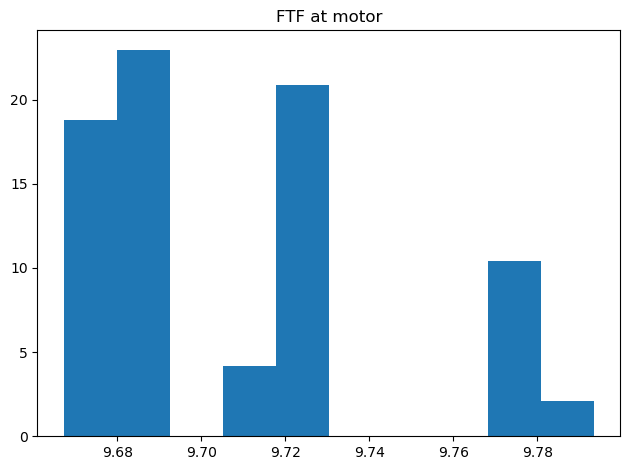

57.398741654910125


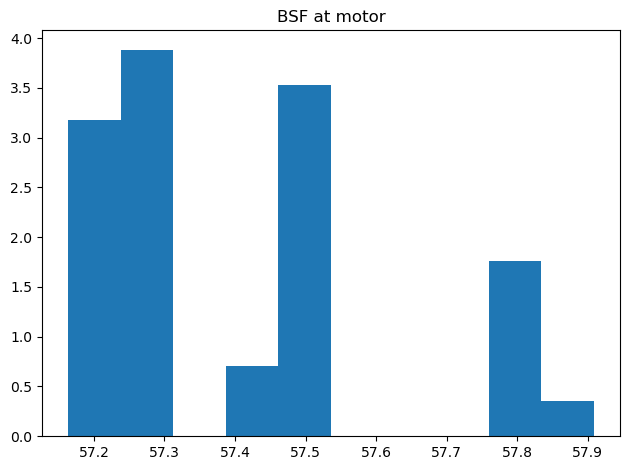

87.36377564681258


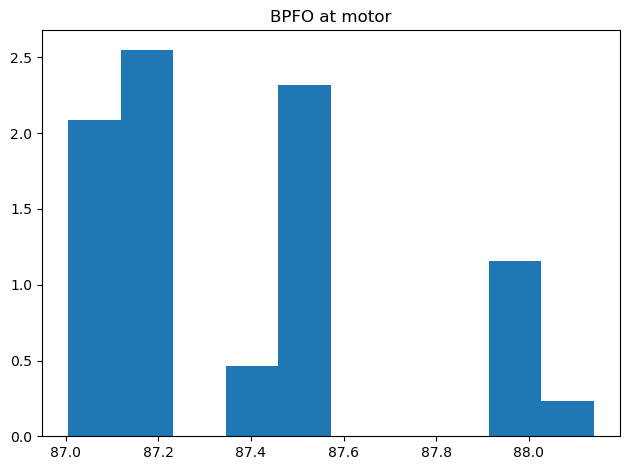

132.0159970803583


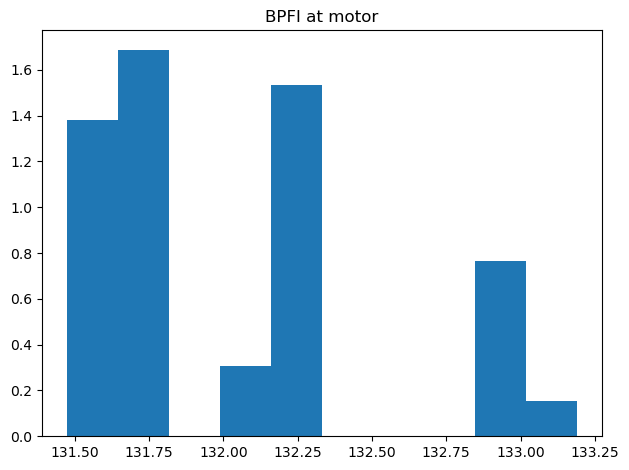

28.97085231717646


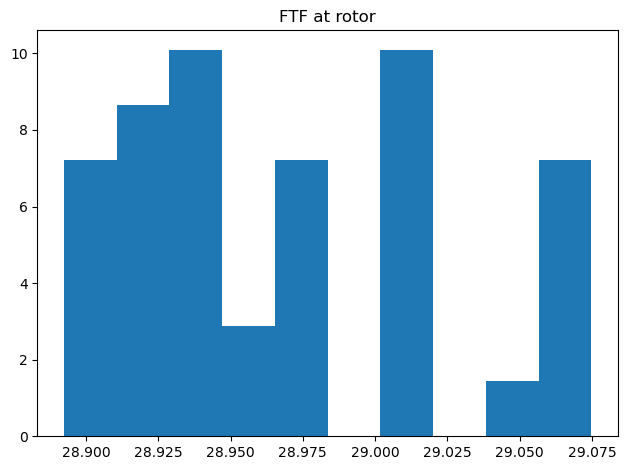

171.30686143406757


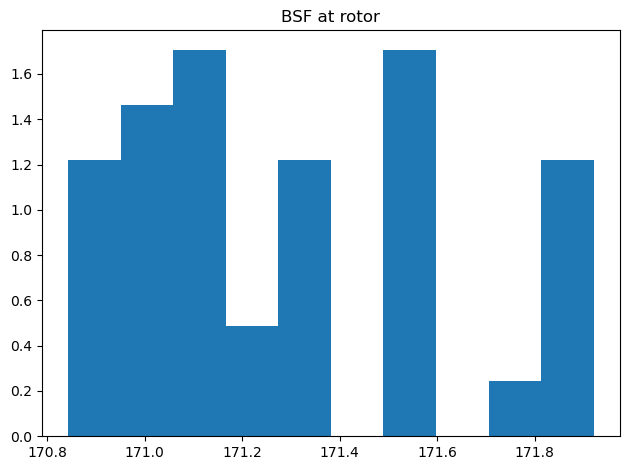

260.7376708545882


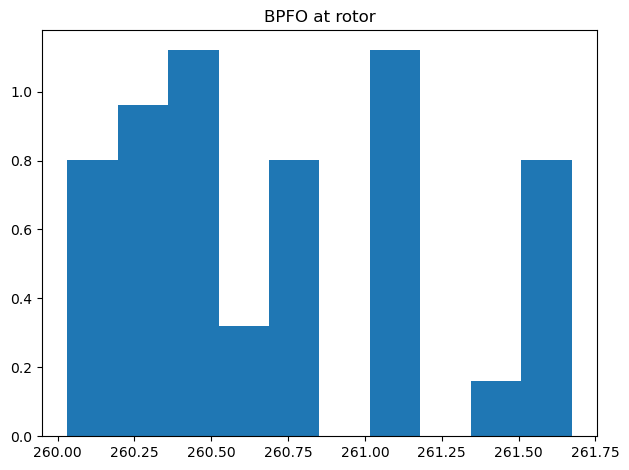

394.0024722996798


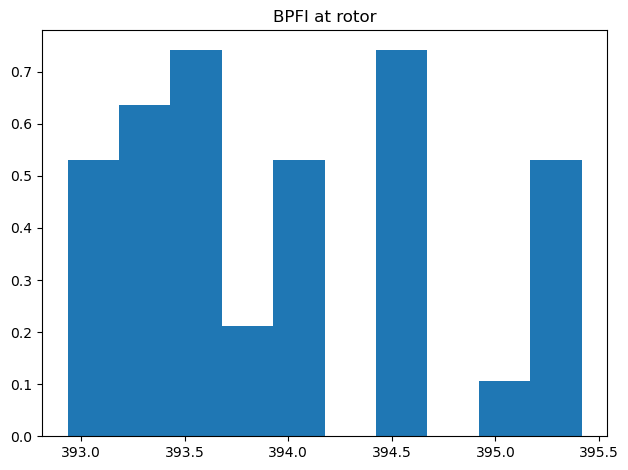

48.751060606038


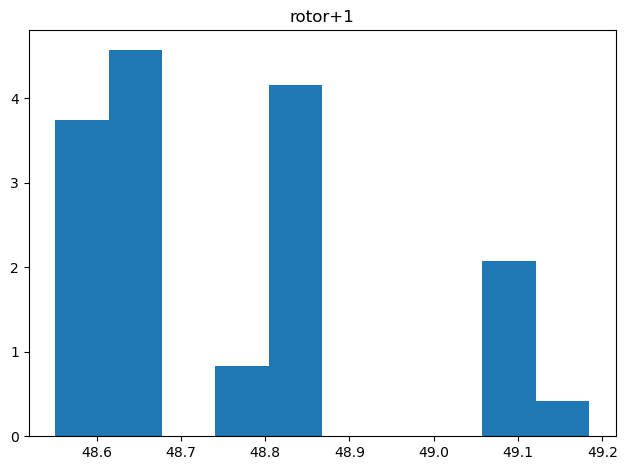

48.37512831637813


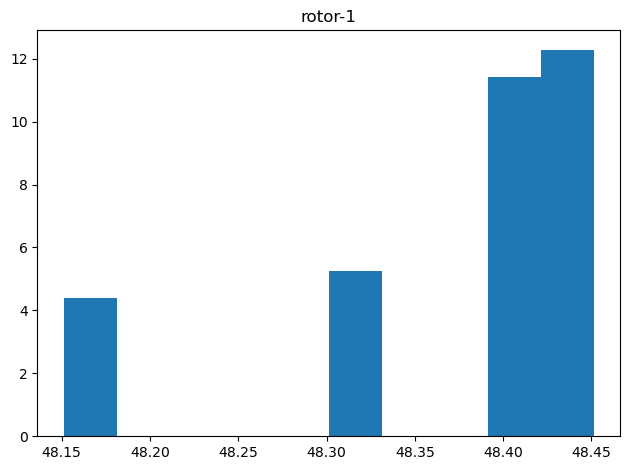

48.939026750867946


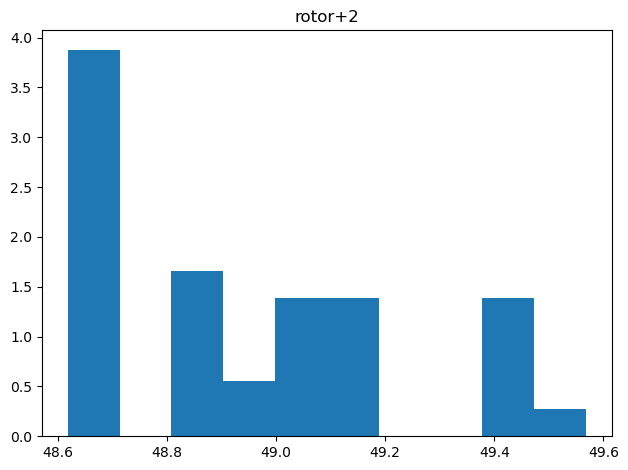

48.18716217154823


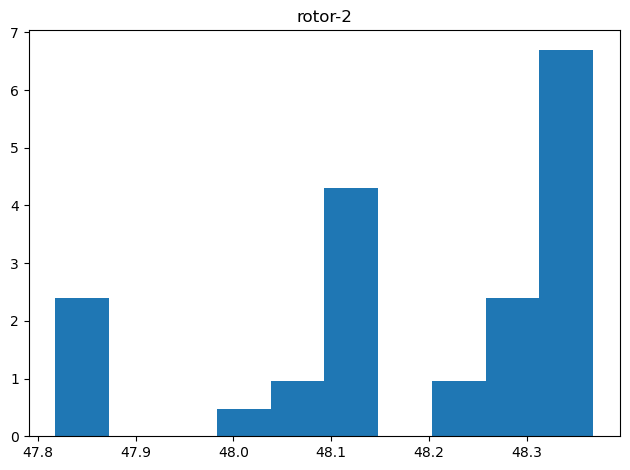

97.12618892241612


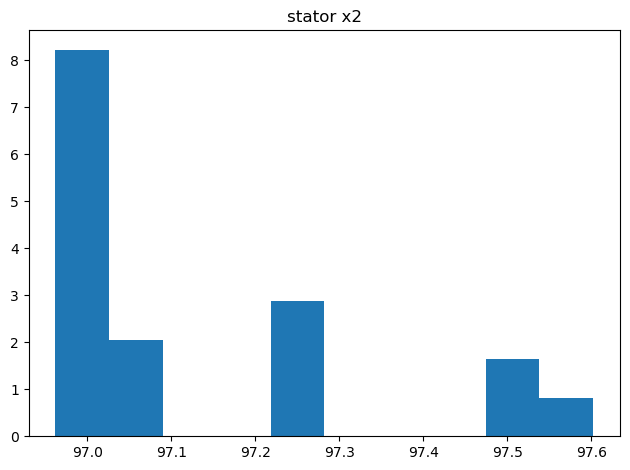

145.68928338362426


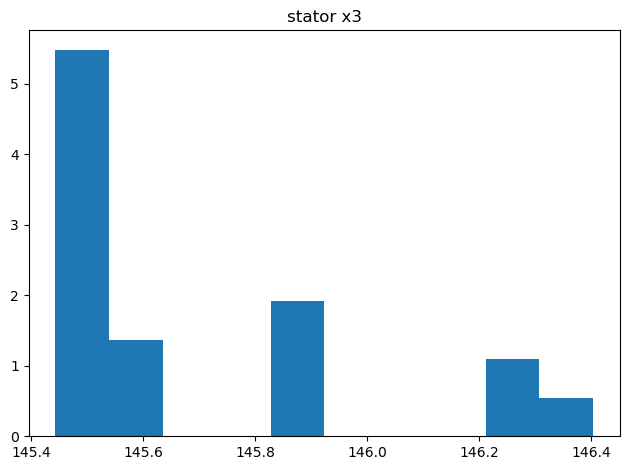

In [182]:
# Fining most 
for i in globalFreqinces:
    print(globalFreqinces[i].mean())
    # Строим график по амплитудам
    plt.hist(globalFreqinces[i].values, density=True)  # density=False would make counts
    plt.title(i)
    plt.tight_layout()
    plt.show()

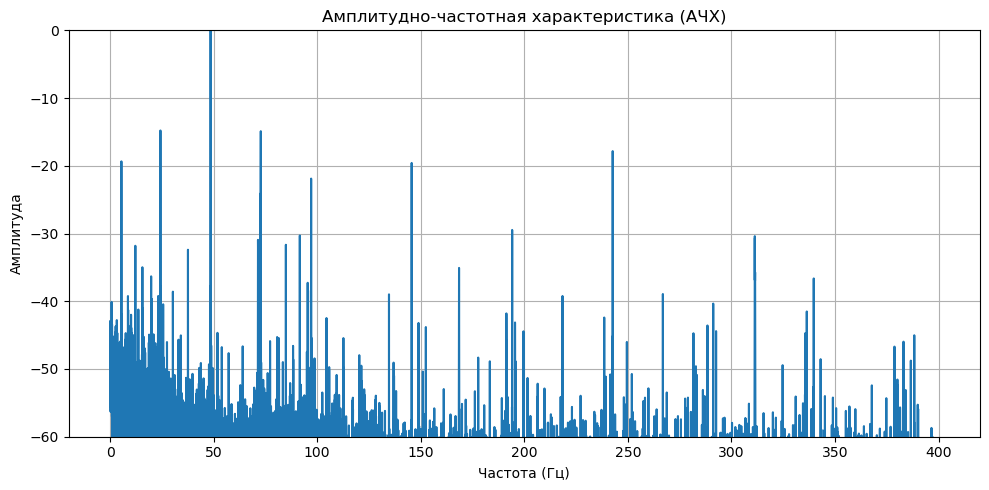

Power grid freqince: 48.5344538077647
Electric motor rotation frequnces: 24.308880228468485
Rotor after multiplicator: 72.76002738706092
Num poles: 2
Slide: 0.0017164435290079262

Posible dangerous freqinces
Freq: 9.680544072521641 type: FTF
Freq: 57.241796129506284 type: BSF
Freq: 87.12489665269479 type: BPFO
Freq: 131.6550254035216 type: BPFI
Freq: 28.975281675601103 type: FTF
Freq: 171.33305256857707 type: BSF
Freq: 260.77753508040996 type: BPFO
Freq: 394.0627114031383 type: BPFI
Freq: 48.61776045693698 type: rotor+1
Freq: 48.45114715859243 type: rotor-1
Freq: 48.70106710610924 type: rotor+2
Freq: 48.367840509420155 type: rotor-2
Freq: 97.0689076155294 type: stator x2
Freq: 145.6033614232941 type: stator x3

Closest freqinces
Freq: 57.241796129506284 type: BSF
Freq: 48.61776045693698 type: rotor+1
Freq: 48.45114715859243 type: rotor-1
Freq: 97.0689076155294 type: stator x2
Freq: 145.6033614232941 type: stator x3


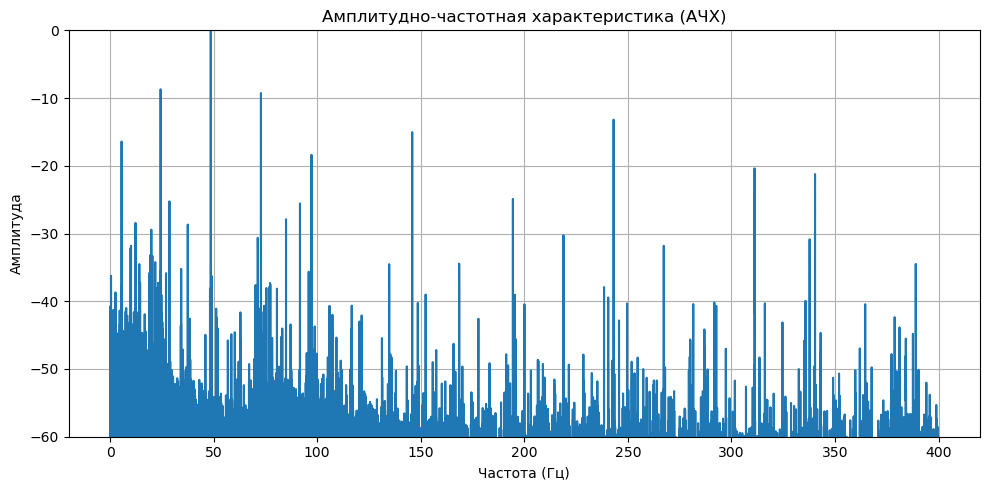

Power grid freqince: 48.617776277968346
Electric motor rotation frequnces: 24.400525482893983
Rotor after multiplicator: 72.84335774067087
Num poles: 2
Slide: 0.003769705277587363

Posible dangerous freqinces
Freq: 9.717040032687857 type: FTF
Freq: 57.45759952813085 type: BSF
Freq: 87.45336029419072 type: BPFO
Freq: 132.1513690518551 type: BPFI
Freq: 29.008466386419467 type: FTF
Freq: 171.52927629702154 type: BSF
Freq: 261.0761974777752 type: BPFO
Freq: 394.5140221882626 type: BPFI
Freq: 48.801050965787965 type: rotor+1
Freq: 48.43450159014873 type: rotor-1
Freq: 48.984325653607584 type: rotor+2
Freq: 48.25122690232911 type: rotor-2
Freq: 97.23555255593669 type: stator x2
Freq: 145.85332883390504 type: stator x3

Closest freqinces
Freq: 171.52927629702154 type: BSF
Freq: 97.23555255593669 type: stator x2
Freq: 145.85332883390504 type: stator x3


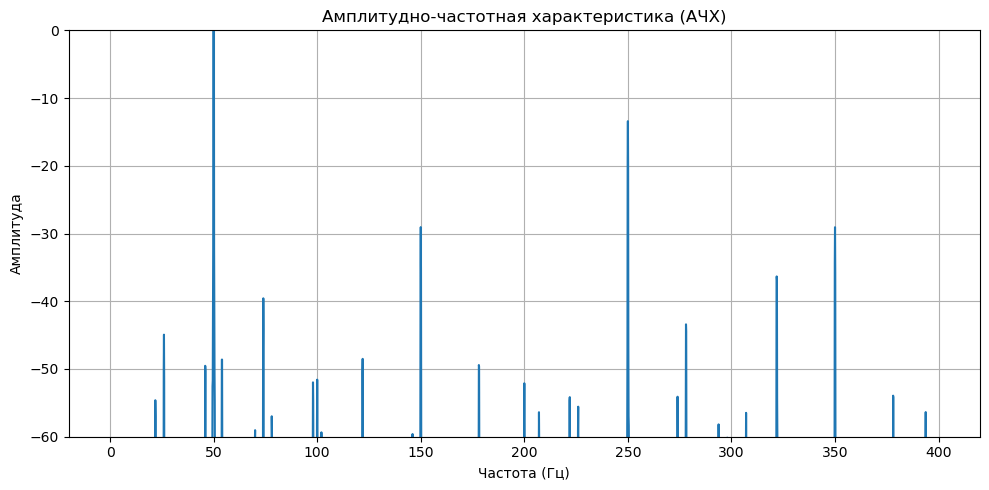

Power grid freqince: 49.99947553757399
Electric motor rotation frequnces: 26.016857720836146
Rotor after multiplicator: 249.99737768786994
Num poles: 2
Slide: 0.04068522483940043

Posible dangerous freqinces
Freq: 10.360713263136056 type: FTF
Freq: 61.26368847884608 type: BSF
Freq: 93.24641936822451 type: BPFO
Freq: 140.90530011930082 type: BPFI
Freq: 99.55664802231558 type: FTF
Freq: 588.6860600745085 type: BSF
Freq: 896.0098322008403 type: BPFO
Freq: 1353.966566989989 type: BPFI
Freq: 52.0337154416723 type: rotor+1
Freq: 47.96523563347569 type: rotor-1
Freq: 54.06795534577059 type: rotor+2
Freq: 45.93099572937739 type: rotor-2
Freq: 99.99895107514799 type: stator x2
Freq: 149.99842661272197 type: stator x3

Closest freqinces
Freq: 99.99895107514799 type: stator x2
Freq: 149.99842661272197 type: stator x3


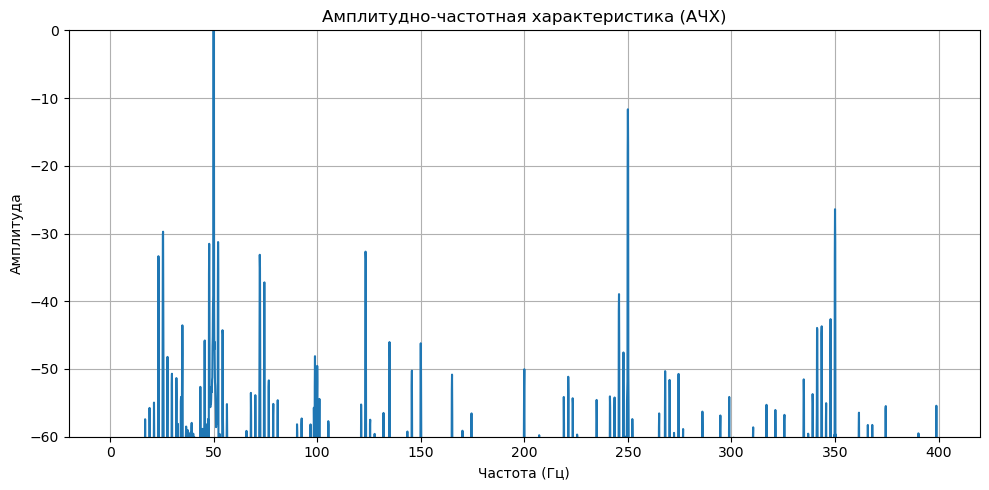

Power grid freqince: 49.99947553757399
Electric motor rotation frequnces: 25.588596688394396
Rotor after multiplicator: 249.99737768786994
Num poles: 2
Slide: 0.023554603854389625

Posible dangerous freqinces
Freq: 10.190166542755215 type: FTF
Freq: 60.25523270141651 type: BSF
Freq: 91.71149888479694 type: BPFO
Freq: 138.58587131075262 type: BPFI
Freq: 99.55664802231558 type: FTF
Freq: 588.6860600745085 type: BSF
Freq: 896.0098322008403 type: BPFO
Freq: 1353.966566989989 type: BPFI
Freq: 51.17719337678879 type: rotor+1
Freq: 48.82175769835919 type: rotor-1
Freq: 52.3549112160036 type: rotor+2
Freq: 47.64403985914439 type: rotor-2
Freq: 99.99895107514799 type: stator x2
Freq: 149.99842661272197 type: stator x3

Closest freqinces
Freq: 149.99842661272197 type: stator x3


In [17]:
graphs = [[df[0], 25600], [df[37], 25600], [dfClear, 1429], [dfBarFailure, 1429]]
index = 0

# Building all graphs
for i in graphs:
    analyze(i[0], i[1], str(index))
    index += 1
